In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
from numpy.random import randn
from IPython.display import clear_output

In [2]:
matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [4]:
resources = "resources/"
models = "models/"

In [5]:
# Define the function that produces the real data
def real_fn(x):
    return x*x + 3*x + 2

def get_real_samples(n=5000, scale=50):
    data = []
    x = scale * randn(n)

    for i in range(n):
        y = real_fn(x[i])
        data.append([x[i], y])

    return torch.FloatTensor(data)

In [18]:
# Noise that is given as input to the generator
def noise_data(n=5000, elements=5):
    return torch.randn(size=[n, elements])

In [19]:
noise_data(5)

tensor([[ 1.0577,  0.5479, -1.1001, -0.0786,  0.3820],
        [ 0.4570,  1.8902,  0.7544,  0.3823,  0.6265],
        [-0.1251, -0.3751, -0.9875,  0.3568,  0.4107],
        [-2.2759,  0.7177,  0.2596, -0.4408,  1.5769],
        [-0.0963,  0.3768, -1.3629,  0.7077,  1.1328]])

In [7]:
class Generator(nn.Module):
    def __init__(self, input_len=5, hidden_len=16, output_len=2):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_len, hidden_len),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_len, hidden_len),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_len, output_len)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

generator = Generator()

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_len=2, hidden_len=16, output_len=1):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_len, hidden_len),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_len, hidden_len),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_len, output_len),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

discriminator = Discriminator()

In [9]:
d_lr = 1e-3
g_lr = 1e-3
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr)
g_optimizer = optim.Adam(generator.parameters(), lr=g_lr)
loss = nn.BCELoss()

In [10]:
# Load the pre trained weights
# generator.load_state_dict(torch.load(models+'generator.pth'))
# discriminator.load_state_dict(torch.load(models+'discriminator.pth'))
# g_optimizer.load_state_dict(torch.load(models+'g_optimizer.pth'))
# d_optimizer.load_state_dict(torch.load(models+'d_optimizer.pth'))

In [11]:
dtype = torch.cuda.FloatTensor
def ones_target(size):
#     Instead of having 1 as the target, one-sided label smoothing replaces the target witth 0.9 
#     data = Variable(torch.ones(size, 1).type(dtype))
    data = Variable(torch.Tensor(size, 1).fill_(0.9).type(dtype))
    return data

def zeros_target(size):
    data = Variable(torch.zeros(size, 1).type(dtype))
    return data

In [12]:
def train_discriminator(optimizer, real_data, generated_data):
    N = real_data.size(0)
    optimizer.zero_grad()
    
#     Train the discriminator on the real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()
    
#     Now train it on the generated data
    prediction_generated = discriminator(generated_data)
    error_generated = loss(prediction_generated, zeros_target(N))
    error_generated.backward()

    optimizer.step()

    return error_real + error_generated, prediction_real, prediction_generated

In [13]:
def train_generator(optimizer, generated_data):
    N = generated_data.size(0)
    optimizer.zero_grad()
    
#     Run the generated data through the discriminator
    prediction = discriminator(generated_data)

#     Train the generator with the flipped targets, i.e. the target is 0.9
    error = loss(prediction, ones_target(N))
    error.backward()

    optimizer.step()

    return error

In [14]:
num_test_samples = 256
discriminator_steps = 20
generator_steps = 20
num_epochs = 5000
printing_epoch = 100
# Move the model to the GPU if available
discriminator.to(device)
generator.to(device)
d_losses = []
g_losses = []

In [26]:
def current_status(real, generated, epoch):
    x, y = zip(*generated.tolist())
    plt.scatter(x, y, label='Generated Data')
    x, y = zip(*real.tolist())
    plt.scatter(x, y, label='Real Data')
    plt.legend(loc='upper right')
    plt.xlabel("input")
    plt.title("Comparsion of Real vs Generated Data - Epoch %s" %epoch)
    n=str(epoch).zfill(4)
    save_location = resources+ 'outputs/epoch-%s.png' %n
    plt.savefig(save_location, bbox_inches='tight')
    plt.show()

def plot_losses(disc, gene):
    plt.plot(disc, label='Discriminator Loss')
    plt.plot(gene, label='Generator Loss')
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Discriminator and Generator Loss")
    save_location = resources+ 'loss.png'
    plt.savefig(save_location, bbox_inches='tight')
    plt.show()

Epoch
4900
Discriminator Loss:
1.3735406398773193
Generator Loss:
0.788763165473938


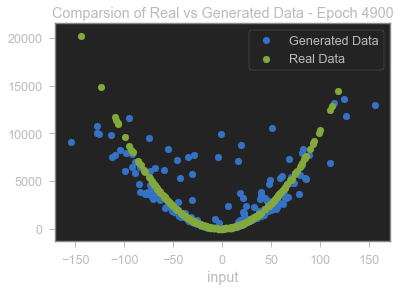

In [21]:
# Set the models to training mode
discriminator.train()
generator.train()

for epoch in range(num_epochs):
    real_data = None
    generated_data = None
    
    for d_steps in range(discriminator_steps):
        real_data = get_real_samples(n=num_test_samples)
        generator_input = noise_data(n=num_test_samples)
        generator_input = generator_input.to(device)
        
#         Dont calculate gradients for this
        generated_data = generator(generator_input).detach()
    
        generated_data = generated_data.to(device)
        real_data = real_data.to(device)
        
        d_error, d_pred_real, d_pred_generated = \
            train_discriminator(
                d_optimizer, real_data, generated_data)
        d_losses.append(d_error.item())
    
    for g_steps in range(generator_steps):
        generator_input = noise_data(n=num_test_samples)
        generator_input = generator_input.to(device)
        
        generated_data = generator(generator_input)
        
        g_error = train_generator(g_optimizer, generated_data)
        g_losses.append(g_error.item())
    
    if(epoch % printing_epoch == 0):
        clear_output()
        print("Epoch")
        print(epoch)
        print("Discriminator Loss:")
        print(d_error.item())
        print("Generator Loss:")
        print(g_error.item())
        current_status(real_data, generated_data, epoch)

In [22]:
# Save the models to disk to be loaded later if neccesary
torch.save(generator.state_dict(), models+'generator.pth')
torch.save(discriminator.state_dict(), models+'discriminator.pth')
torch.save(g_optimizer.state_dict(), models+'g_optimizer.pth')
torch.save(d_optimizer.state_dict(), models+'d_optimizer.pth')

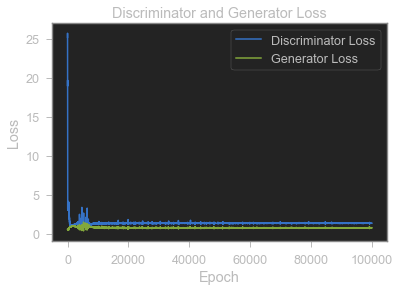

In [23]:
plot_losses(d_losses, g_losses)

In [24]:
# To produce a gif from the output images saved to disk. You have to install imagemagick
! convert -resize 80% -delay 10 -loop 0 resources/outputs/*.png resources/outputs/output.gif